# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [20]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
iters = 2000
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=iters)
        
        y_train_pred = svm.predict(X_train_feats) 
        acc_train = np.mean(y_train == y_train_pred)  
        
        y_val_pred = svm.predict(X_val_feats) 
        acc_val = np.mean(y_val == y_val_pred) 
        
        results[(lr, reg)] = (acc_train, acc_val)
        if best_val < acc_val:
            best_val = acc_val
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.096755 val accuracy: 0.109000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.115551 val accuracy: 0.094000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.366347 val accuracy: 0.338000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.104714 val accuracy: 0.098000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.408755 val accuracy: 0.400000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.412898 val accuracy: 0.417000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.410694 val accuracy: 0.409000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.416469 val accuracy: 0.411000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.365959 val accuracy: 0.343000
best validation accuracy achieved during cross-validation: 0.417000


In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.417


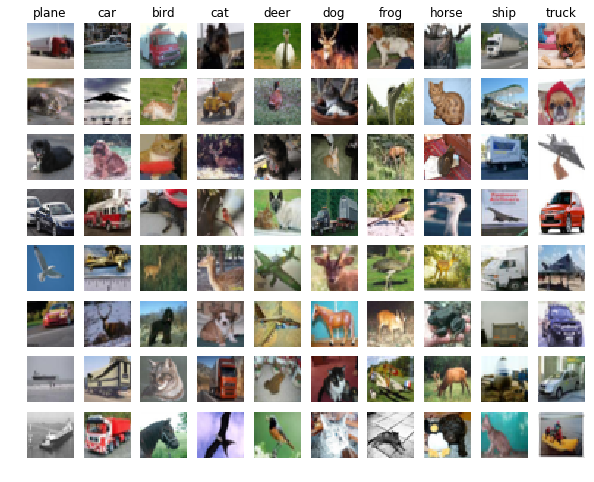

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
print(X_train_feats.shape)

(49000, 155)


 batch_size: 200, lr: 0.100000, reg: 0.001000
iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 2.302797
iteration 200 / 1500: loss 2.117359
iteration 300 / 1500: loss 1.837364
iteration 400 / 1500: loss 1.560867
iteration 500 / 1500: loss 1.466111
iteration 600 / 1500: loss 1.562893
iteration 700 / 1500: loss 1.404395
iteration 800 / 1500: loss 1.341673
iteration 900 / 1500: loss 1.334706
iteration 1000 / 1500: loss 1.503774
iteration 1100 / 1500: loss 1.367205
iteration 1200 / 1500: loss 1.484333
iteration 1300 / 1500: loss 1.331921
iteration 1400 / 1500: loss 1.306035
Validation accuracy:  0.525


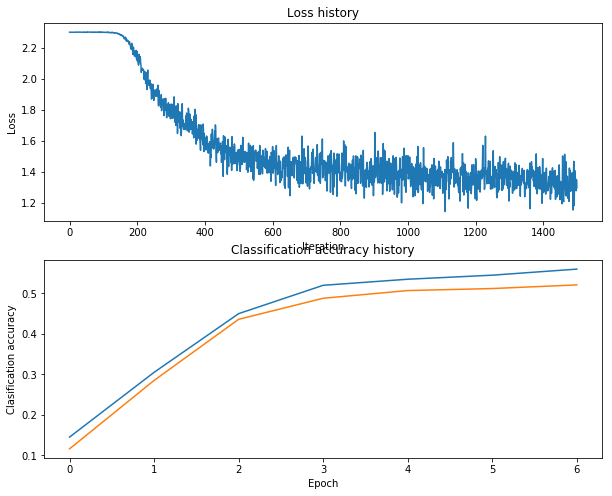

 batch_size: 200, lr: 0.100000, reg: 0.005000
iteration 0 / 1500: loss 2.302589
iteration 100 / 1500: loss 2.303620
iteration 200 / 1500: loss 2.142870
iteration 300 / 1500: loss 1.837105
iteration 400 / 1500: loss 1.636224
iteration 500 / 1500: loss 1.634417
iteration 600 / 1500: loss 1.464281
iteration 700 / 1500: loss 1.457652
iteration 800 / 1500: loss 1.515712
iteration 900 / 1500: loss 1.502770
iteration 1000 / 1500: loss 1.421140
iteration 1100 / 1500: loss 1.518867
iteration 1200 / 1500: loss 1.397325
iteration 1300 / 1500: loss 1.570948
iteration 1400 / 1500: loss 1.491610
Validation accuracy:  0.521


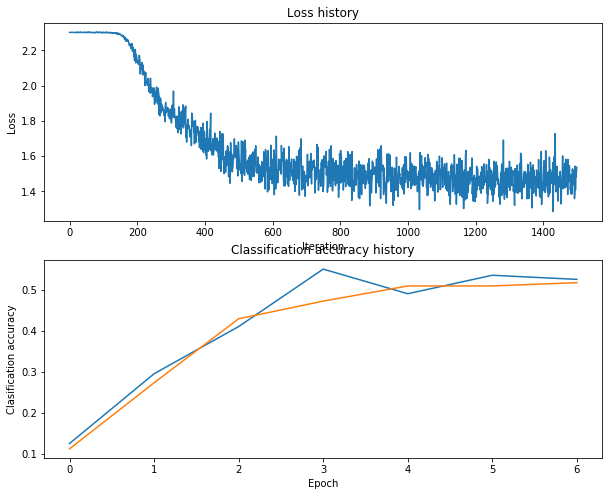

 batch_size: 200, lr: 0.100000, reg: 0.010000
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 2.303479
iteration 200 / 1500: loss 2.144747
iteration 300 / 1500: loss 1.944816
iteration 400 / 1500: loss 1.712624
iteration 500 / 1500: loss 1.699002
iteration 600 / 1500: loss 1.587256
iteration 700 / 1500: loss 1.674844
iteration 800 / 1500: loss 1.561716
iteration 900 / 1500: loss 1.508887
iteration 1000 / 1500: loss 1.467653
iteration 1100 / 1500: loss 1.561251
iteration 1200 / 1500: loss 1.696151
iteration 1300 / 1500: loss 1.646845
iteration 1400 / 1500: loss 1.508086
Validation accuracy:  0.51


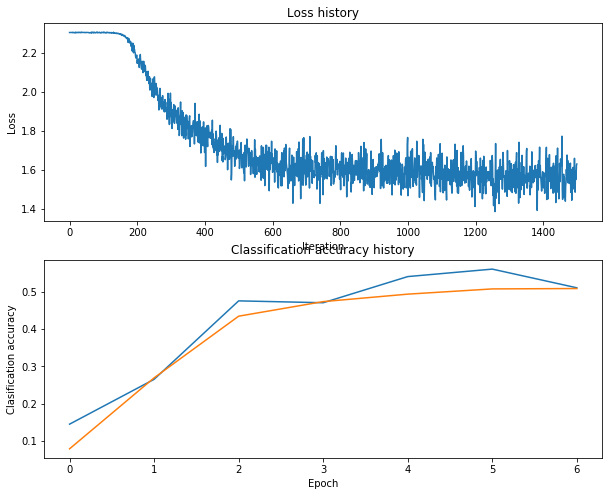

 batch_size: 200, lr: 0.500000, reg: 0.001000
iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 1.536422
iteration 200 / 1500: loss 1.255967
iteration 300 / 1500: loss 1.301026
iteration 400 / 1500: loss 1.450855
iteration 500 / 1500: loss 1.234150
iteration 600 / 1500: loss 1.305285
iteration 700 / 1500: loss 1.287211
iteration 800 / 1500: loss 1.260089
iteration 900 / 1500: loss 1.243169
iteration 1000 / 1500: loss 1.244731
iteration 1100 / 1500: loss 1.140198
iteration 1200 / 1500: loss 1.240691
iteration 1300 / 1500: loss 1.042314
iteration 1400 / 1500: loss 1.253900
Validation accuracy:  0.585


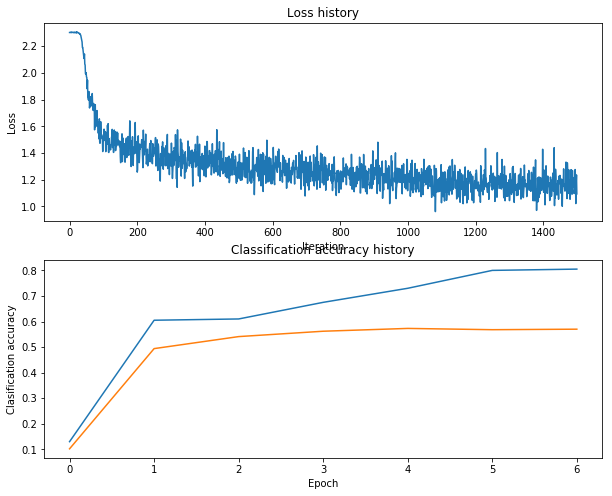

 batch_size: 200, lr: 0.500000, reg: 0.005000
iteration 0 / 1500: loss 2.302589
iteration 100 / 1500: loss 1.618882
iteration 200 / 1500: loss 1.395048
iteration 300 / 1500: loss 1.621374
iteration 400 / 1500: loss 1.451068
iteration 500 / 1500: loss 1.492997
iteration 600 / 1500: loss 1.479125
iteration 700 / 1500: loss 1.437823
iteration 800 / 1500: loss 1.460161
iteration 900 / 1500: loss 1.618315
iteration 1000 / 1500: loss 1.535194
iteration 1100 / 1500: loss 1.451478
iteration 1200 / 1500: loss 1.548499
iteration 1300 / 1500: loss 1.461729
iteration 1400 / 1500: loss 1.458524
Validation accuracy:  0.549


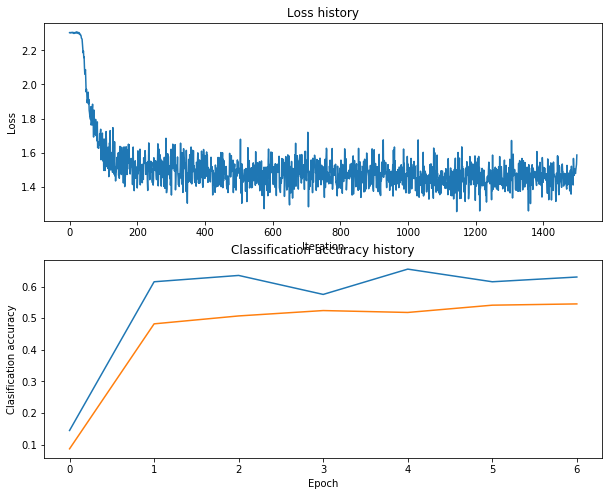

 batch_size: 200, lr: 0.500000, reg: 0.010000
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.768264
iteration 200 / 1500: loss 1.659516
iteration 300 / 1500: loss 1.538205
iteration 400 / 1500: loss 1.723356
iteration 500 / 1500: loss 1.535052
iteration 600 / 1500: loss 1.602149
iteration 700 / 1500: loss 1.536311
iteration 800 / 1500: loss 1.671030
iteration 900 / 1500: loss 1.601398
iteration 1000 / 1500: loss 1.652110
iteration 1100 / 1500: loss 1.595700
iteration 1200 / 1500: loss 1.548955
iteration 1300 / 1500: loss 1.575801
iteration 1400 / 1500: loss 1.693717
Validation accuracy:  0.508


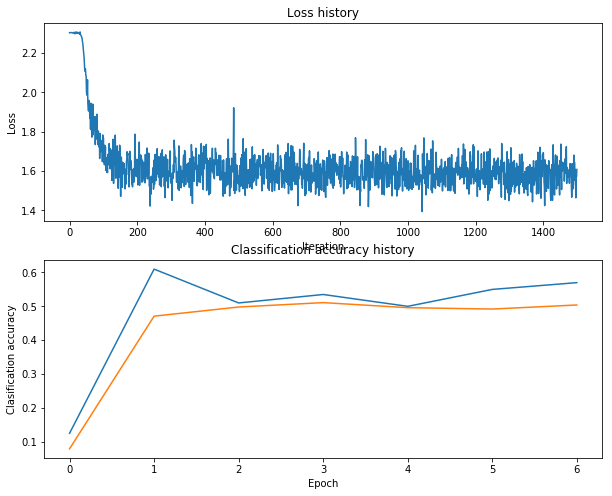

 batch_size: 200, lr: 1.000000, reg: 0.001000
iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 1.627882
iteration 200 / 1500: loss 1.441119
iteration 300 / 1500: loss 1.400322
iteration 400 / 1500: loss 1.345825
iteration 500 / 1500: loss 1.315599
iteration 600 / 1500: loss 1.355265
iteration 700 / 1500: loss 1.338058
iteration 800 / 1500: loss 1.212148
iteration 900 / 1500: loss 1.204300
iteration 1000 / 1500: loss 1.296456
iteration 1100 / 1500: loss 1.272602
iteration 1200 / 1500: loss 1.067565
iteration 1300 / 1500: loss 1.238273
iteration 1400 / 1500: loss 1.284779
Validation accuracy:  0.575


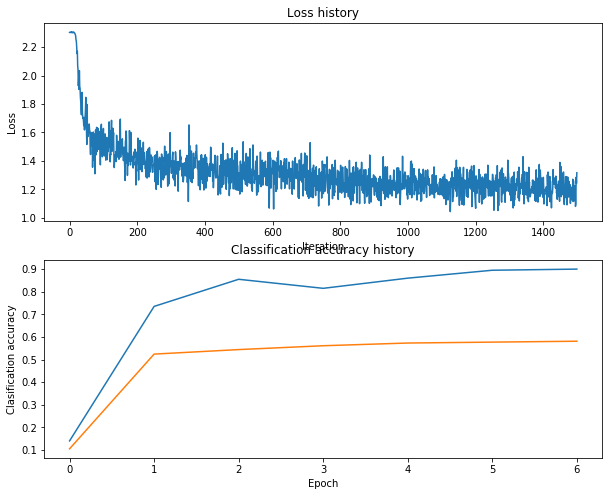

 batch_size: 200, lr: 1.000000, reg: 0.005000
iteration 0 / 1500: loss 2.302589
iteration 100 / 1500: loss 1.541557
iteration 200 / 1500: loss 1.455281
iteration 300 / 1500: loss 1.523282
iteration 400 / 1500: loss 1.546369
iteration 500 / 1500: loss 1.599998
iteration 600 / 1500: loss 1.570856
iteration 700 / 1500: loss 1.390623
iteration 800 / 1500: loss 1.359320
iteration 900 / 1500: loss 1.538412
iteration 1000 / 1500: loss 1.497031
iteration 1100 / 1500: loss 1.488373
iteration 1200 / 1500: loss 1.466307
iteration 1300 / 1500: loss 1.504023
iteration 1400 / 1500: loss 1.555091
Validation accuracy:  0.525


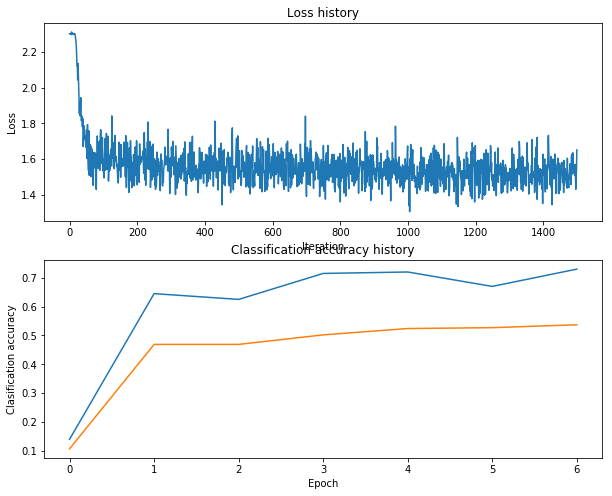

 batch_size: 200, lr: 1.000000, reg: 0.010000
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.757170
iteration 200 / 1500: loss 1.695441
iteration 300 / 1500: loss 1.641844
iteration 400 / 1500: loss 1.662010
iteration 500 / 1500: loss 1.602261
iteration 600 / 1500: loss 1.591438
iteration 700 / 1500: loss 1.781994
iteration 800 / 1500: loss 1.767448
iteration 900 / 1500: loss 1.527247
iteration 1000 / 1500: loss 1.757919
iteration 1100 / 1500: loss 1.689321
iteration 1200 / 1500: loss 1.732699
iteration 1300 / 1500: loss 1.576649
iteration 1400 / 1500: loss 1.668436
Validation accuracy:  0.483


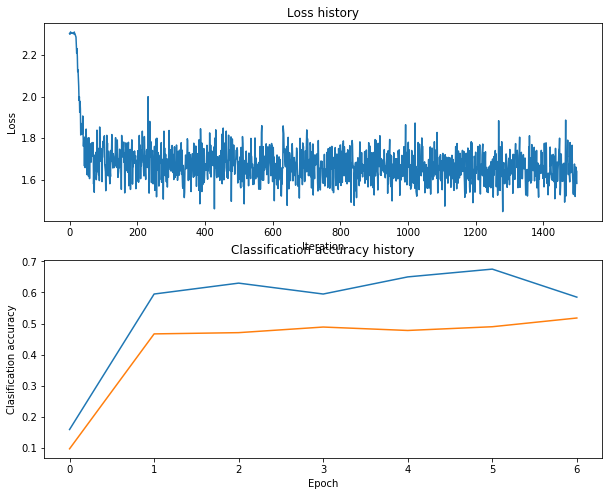

 batch_size: 300, lr: 0.100000, reg: 0.001000
iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 2.301933
iteration 200 / 1500: loss 2.128885
iteration 300 / 1500: loss 1.802902
iteration 400 / 1500: loss 1.588025
iteration 500 / 1500: loss 1.505947
iteration 600 / 1500: loss 1.443602
iteration 700 / 1500: loss 1.370338
iteration 800 / 1500: loss 1.389932
iteration 900 / 1500: loss 1.440504
iteration 1000 / 1500: loss 1.400610
iteration 1100 / 1500: loss 1.380091
iteration 1200 / 1500: loss 1.327249
iteration 1300 / 1500: loss 1.264645
iteration 1400 / 1500: loss 1.248406
Validation accuracy:  0.533


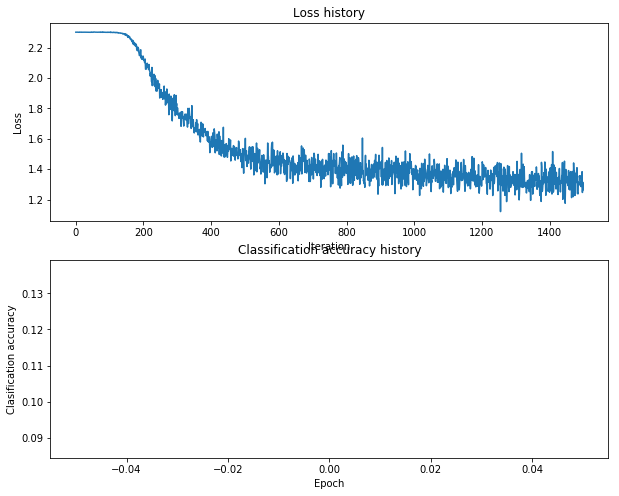

 batch_size: 300, lr: 0.100000, reg: 0.005000
iteration 0 / 1500: loss 2.302589
iteration 100 / 1500: loss 2.301971
iteration 200 / 1500: loss 2.136278
iteration 300 / 1500: loss 1.850810
iteration 400 / 1500: loss 1.698775
iteration 500 / 1500: loss 1.517029
iteration 600 / 1500: loss 1.481684
iteration 700 / 1500: loss 1.652960
iteration 800 / 1500: loss 1.533720
iteration 900 / 1500: loss 1.379630
iteration 1000 / 1500: loss 1.447444
iteration 1100 / 1500: loss 1.515664
iteration 1200 / 1500: loss 1.391522
iteration 1300 / 1500: loss 1.369135
iteration 1400 / 1500: loss 1.597917
Validation accuracy:  0.515


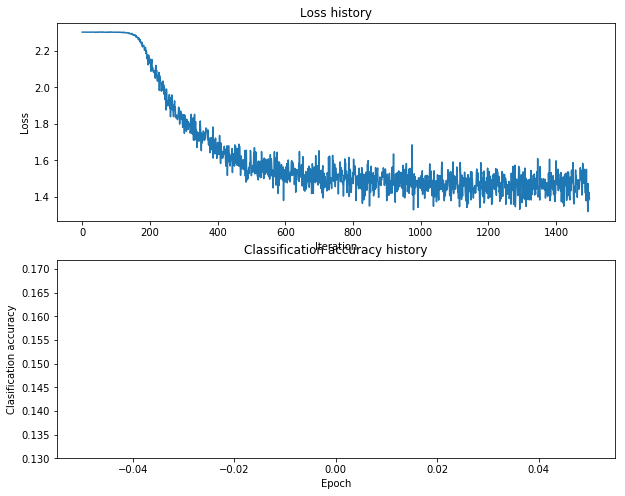

 batch_size: 300, lr: 0.100000, reg: 0.010000
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 2.301652
iteration 200 / 1500: loss 2.181680
iteration 300 / 1500: loss 1.907877
iteration 400 / 1500: loss 1.739009
iteration 500 / 1500: loss 1.623972
iteration 600 / 1500: loss 1.595925
iteration 700 / 1500: loss 1.628249
iteration 800 / 1500: loss 1.632483
iteration 900 / 1500: loss 1.585310
iteration 1000 / 1500: loss 1.586991
iteration 1100 / 1500: loss 1.578956
iteration 1200 / 1500: loss 1.569626
iteration 1300 / 1500: loss 1.581574
iteration 1400 / 1500: loss 1.496418
Validation accuracy:  0.5


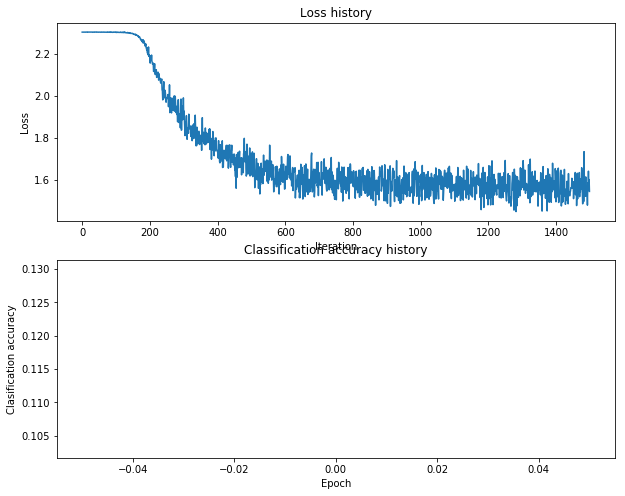

 batch_size: 300, lr: 0.500000, reg: 0.001000
iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 1.645245
iteration 200 / 1500: loss 1.464249
iteration 300 / 1500: loss 1.380657
iteration 400 / 1500: loss 1.262614
iteration 500 / 1500: loss 1.300309
iteration 600 / 1500: loss 1.216344
iteration 700 / 1500: loss 1.195092
iteration 800 / 1500: loss 1.216326
iteration 900 / 1500: loss 1.162337
iteration 1000 / 1500: loss 1.231984
iteration 1100 / 1500: loss 1.074321
iteration 1200 / 1500: loss 1.175956
iteration 1300 / 1500: loss 1.124646
iteration 1400 / 1500: loss 1.138853
Validation accuracy:  0.569


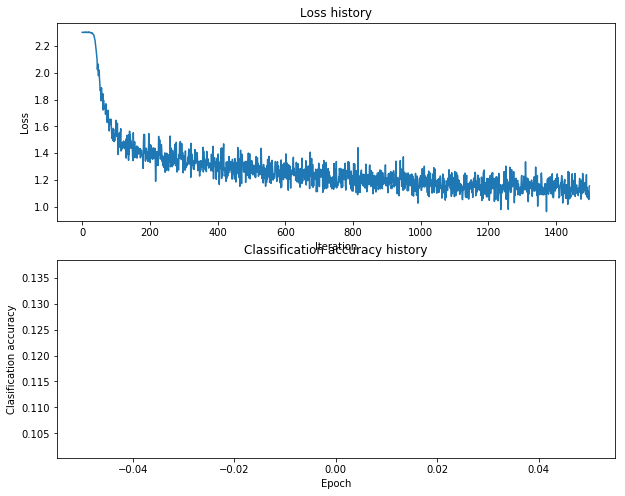

 batch_size: 300, lr: 0.500000, reg: 0.005000
iteration 0 / 1500: loss 2.302589
iteration 100 / 1500: loss 1.635803
iteration 200 / 1500: loss 1.440154
iteration 300 / 1500: loss 1.513450
iteration 400 / 1500: loss 1.480129
iteration 500 / 1500: loss 1.478677
iteration 600 / 1500: loss 1.501305
iteration 700 / 1500: loss 1.521221
iteration 800 / 1500: loss 1.437976
iteration 900 / 1500: loss 1.433560
iteration 1000 / 1500: loss 1.377769
iteration 1100 / 1500: loss 1.543586
iteration 1200 / 1500: loss 1.459214
iteration 1300 / 1500: loss 1.400953
iteration 1400 / 1500: loss 1.446532
Validation accuracy:  0.535


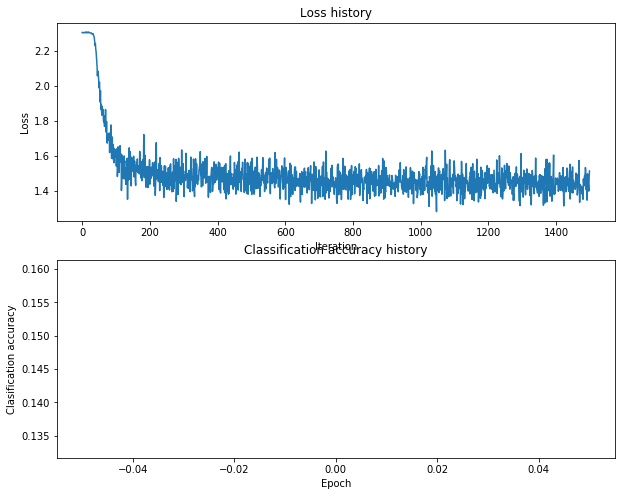

 batch_size: 300, lr: 0.500000, reg: 0.010000
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.728346
iteration 200 / 1500: loss 1.642062
iteration 300 / 1500: loss 1.635103
iteration 400 / 1500: loss 1.418228
iteration 500 / 1500: loss 1.600908
iteration 600 / 1500: loss 1.597895
iteration 700 / 1500: loss 1.574972
iteration 800 / 1500: loss 1.569211
iteration 900 / 1500: loss 1.530723
iteration 1000 / 1500: loss 1.637685
iteration 1100 / 1500: loss 1.550555
iteration 1200 / 1500: loss 1.556235
iteration 1300 / 1500: loss 1.582089
iteration 1400 / 1500: loss 1.574814
Validation accuracy:  0.486


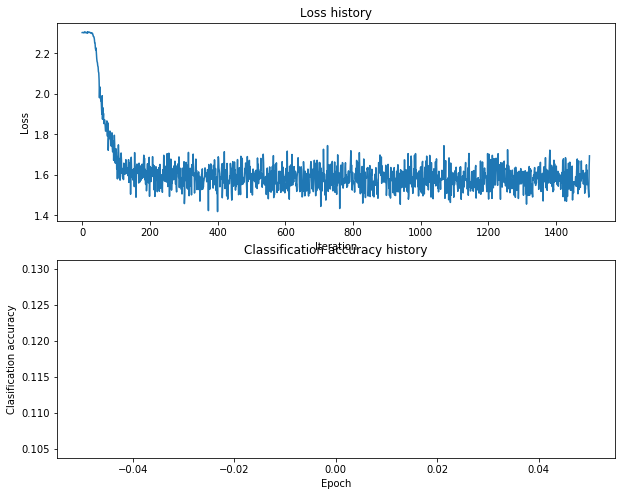

 batch_size: 300, lr: 1.000000, reg: 0.001000
iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 1.552762
iteration 200 / 1500: loss 1.420438
iteration 300 / 1500: loss 1.476106
iteration 400 / 1500: loss 1.347239
iteration 500 / 1500: loss 1.308738
iteration 600 / 1500: loss 1.131428
iteration 700 / 1500: loss 1.238331
iteration 800 / 1500: loss 1.223230
iteration 900 / 1500: loss 1.182187
iteration 1000 / 1500: loss 1.283565
iteration 1100 / 1500: loss 1.266362
iteration 1200 / 1500: loss 1.186327
iteration 1300 / 1500: loss 1.341121
iteration 1400 / 1500: loss 1.264200
Validation accuracy:  0.585


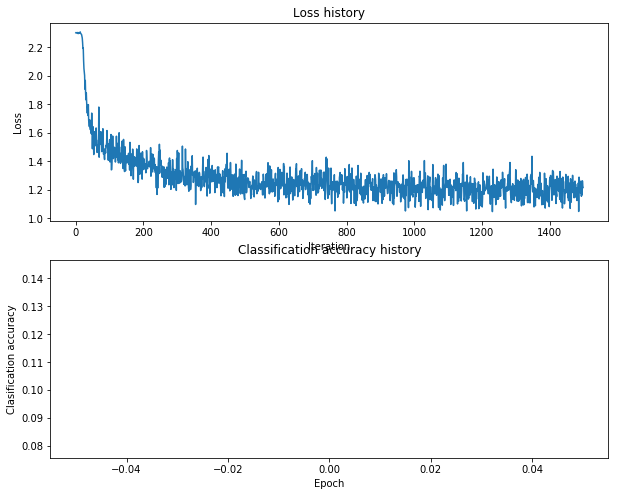

 batch_size: 300, lr: 1.000000, reg: 0.005000
iteration 0 / 1500: loss 2.302589
iteration 100 / 1500: loss 1.598762
iteration 200 / 1500: loss 1.444697
iteration 300 / 1500: loss 1.510076
iteration 400 / 1500: loss 1.523018
iteration 500 / 1500: loss 1.523470
iteration 600 / 1500: loss 1.602831
iteration 700 / 1500: loss 1.528663
iteration 800 / 1500: loss 1.532187
iteration 900 / 1500: loss 1.560259
iteration 1000 / 1500: loss 1.521260
iteration 1100 / 1500: loss 1.597761
iteration 1200 / 1500: loss 1.540157
iteration 1300 / 1500: loss 1.534462
iteration 1400 / 1500: loss 1.438278
Validation accuracy:  0.504


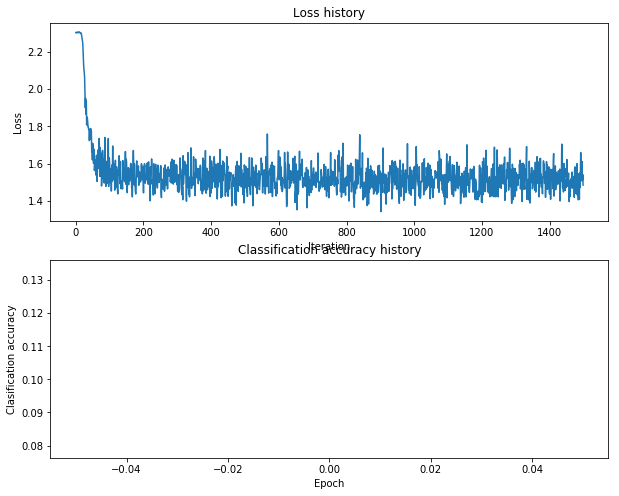

 batch_size: 300, lr: 1.000000, reg: 0.010000
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.573483
iteration 200 / 1500: loss 1.670955
iteration 300 / 1500: loss 1.656171
iteration 400 / 1500: loss 1.574855
iteration 500 / 1500: loss 1.651191
iteration 600 / 1500: loss 1.625685
iteration 700 / 1500: loss 1.532477
iteration 800 / 1500: loss 1.712374
iteration 900 / 1500: loss 1.632284
iteration 1000 / 1500: loss 1.638131
iteration 1100 / 1500: loss 1.634391
iteration 1200 / 1500: loss 1.681483
iteration 1300 / 1500: loss 1.665116
iteration 1400 / 1500: loss 1.684371
Validation accuracy:  0.507


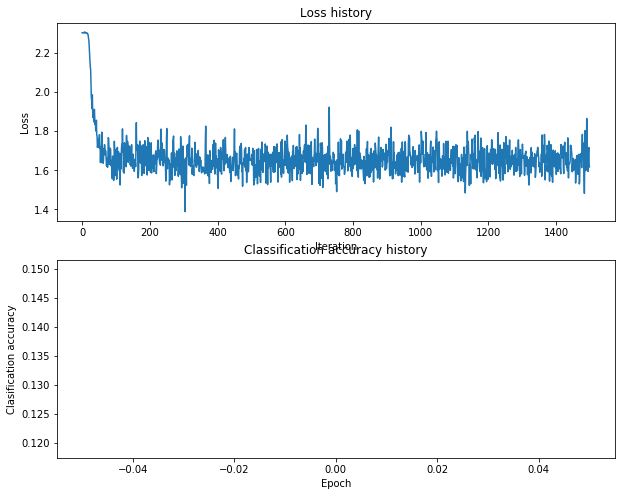

best_val : 0.585000


In [43]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_val = -1
learning_rates = [1e-1, 0.5, 1]
regularization_strengths = [1e-3, 5e-3, 1e-2]
batch_sizes = [200, 300]
for batch_size in batch_sizes:
    for lr in learning_rates:
        for reg in regularization_strengths:
            print(" batch_size: %d, lr: %f, reg: %f"%(batch_size, lr, reg))
            # Train the network
            net = TwoLayerNet(input_dim, hidden_dim, num_classes)
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                            num_iters=1500, batch_size=batch_size,
                            learning_rate=lr, learning_rate_decay=0.95,
                            reg=reg, verbose=True)

            # Predict on the validation set
            val_acc = (net.predict(X_val_feats) == y_val).mean()
            print('Validation accuracy: ', val_acc)
            if val_acc > best_val:
                best_net = net
                best_val = val_acc
                
            plt.subplot(2, 1, 1)
            plt.plot(stats['loss_history'])
            plt.title('Loss history')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')

            plt.subplot(2, 1, 2)
            plt.plot(stats['train_acc_history'], label='train')
            plt.plot(stats['val_acc_history'], label='val')
            plt.title('Classification accuracy history')
            plt.xlabel('Epoch')
            plt.ylabel('Clasification accuracy')
            plt.show()
            
print("best_val : %f"%best_val)
                
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [44]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.588


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!